<a href="https://colab.research.google.com/github/MauriAleman35/Modelos-ERP-Ecommerce/blob/main/regresionLinealML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Preparacion Datos

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  # Cambiado a regresión lineal
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import warnings

# Ignorar advertencias
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# SECCIÓN 1: PREPARACIÓN DE DATOS

def cargar_datos(ruta_ventas, ruta_productos, ruta_ventas_detalle, ruta_clientes):
    """
    Carga los datos desde los archivos Excel con mejor diagnóstico
    """
    try:
        # Cargar los datos
        ventas = pd.read_csv('ventas.csv')
        productos = pd.read_csv('productos.csv')
        ventas_detalle = pd.read_csv('ventadetalles.csv')
        clientes = pd.read_csv('clientes.csv')

        print(f"Ventas: {ventas.shape[0]} registros")
        print(f"Productos: {productos.shape[0]} registros")
        print(f"Ventas detalle: {ventas_detalle.shape[0]} registros")
        print(f"Clientes: {clientes.shape[0]} registros")

        # Mostrar columnas de cada tabla para diagnóstico
        print("\nColumnas en ventas:", ventas.columns.tolist())
        print("Columnas en productos:", productos.columns.tolist())
        print("Columnas en ventas_detalle:", ventas_detalle.columns.tolist())
        print("Columnas en clientes:", clientes.columns.tolist())

        # Mostrar las primeras filas de cada tabla
        print("\nPrimeras filas de ventas:")
        print(ventas.head(2))

        return ventas, productos, ventas_detalle, clientes

    except Exception as e:
        print(f"Error al cargar datos: {e}")
        return None, None, None, None

def preparar_datos_diarios_mongodb(ventas, productos, ventas_detalle, clientes):
    """
    Prepara los datos para análisis diario específicamente para estructura MongoDB,
    con manejo explícito de columnas duplicadas
    """
    try:
        # 1. Renombrar columnas clave para consistencia
        # En ventas
        ventas = ventas.rename(columns={
            '_id': 'id_venta',
            'cliente': 'id_cliente',
            'createdAT': 'fecha',
            'estado': 'estado_venta',  # Renombrar para evitar duplicados
            '__v': '__v_venta'         # Renombrar para evitar duplicados
        })

        # En productos
        productos = productos.rename(columns={
            '_id': 'id_producto',
            'categoria': 'id_categoria',
            'estado': 'estado_producto',  # Renombrar para evitar duplicados
            '__v': '__v_producto',        # Renombrar para evitar duplicados
            'createdAT': 'fecha_producto' # Renombrar para evitar duplicados
        })

        # En ventas_detalle
        ventas_detalle = ventas_detalle.rename(columns={
            'venta': 'id_venta',
            'producto': 'id_producto',
            'cliente': 'id_cliente_detalle',  # Para evitar duplicados en join
            'estado': 'estado_detalle',       # Renombrar para evitar duplicados
            'estado_': 'estado_alt_detalle',  # Renombrar para claridad
            '__v': '__v_detalle',             # Renombrar para evitar duplicados
            'createdAT': 'fecha_detalle'      # Renombrar para evitar duplicados
        })

        # En clientes
        clientes = clientes.rename(columns={
            '_id': 'id_cliente',
            'estado': 'estado_cliente',  # Renombrar para evitar duplicados
            '__v': '__v_cliente',        # Renombrar para evitar duplicados
            'createdAT': 'fecha_cliente' # Renombrar para evitar duplicados
        })

        # 2. Convertir fecha a datetime
        ventas['fecha'] = pd.to_datetime(ventas['fecha'], errors='coerce')

        # 3. Verificar si hay fechas nulas después de la conversión
        if ventas['fecha'].isna().any():
            print(f"ADVERTENCIA: Hay {ventas['fecha'].isna().sum()} valores nulos en la columna fecha")
            # Eliminar filas con fecha nula
            ventas = ventas.dropna(subset=['fecha'])

        # 4. Si no hay fechas válidas, salir
        if len(ventas) == 0:
            print("ERROR: No hay fechas válidas después de la conversión")
            return None

        print("\nDatos renombrados. Procediendo con los joins...")

        # 5. Unir ventas_detalle con productos
        print(f"Ventas detalle antes del join: {len(ventas_detalle)} registros")
        detalle_completo = pd.merge(ventas_detalle, productos, on='id_producto', how='left')
        print(f"Después del join con productos: {len(detalle_completo)} registros")

        # 6. Unir con ventas para obtener fechas
        ventas_completas = pd.merge(detalle_completo, ventas, on='id_venta', how='left')
        print(f"Después del join con ventas: {len(ventas_completas)} registros")

        # 7. Unir con clientes para obtener datos demográficos
        # Ahora especificamos claramente los sufijos para evitar problemas
        datos_completos = pd.merge(
            ventas_completas,
            clientes,
            on='id_cliente',
            how='left'
        )
        print(f"Después del join con clientes: {len(datos_completos)} registros")

        # 8. Verificar si hay datos después de los joins
        if len(datos_completos) == 0:
            print("ERROR: No hay datos después de los joins")
            print("Esto puede deberse a que los IDs no coinciden entre tablas")
            return None

        # 9. Ver una muestra para verificar que los joins funcionaron
        print("\nMuestra de los datos unidos:")
        muestra_cols = ['id_venta', 'id_cliente', 'id_producto', 'fecha', 'total', 'cantidad', 'precio']
        muestra_cols = [col for col in muestra_cols if col in datos_completos.columns]
        print(datos_completos[muestra_cols].head(2))

        # 10. Agrupar por fecha y calcular métricas
        print("\nAgrupando por fecha...")
        # Definimos solo las columnas que sabemos que existen
        agg_dict = {}

        if 'id_venta' in datos_completos.columns:
            agg_dict['id_venta'] = 'nunique'  # Ventas únicas por día

        if 'id_cliente' in datos_completos.columns:
            agg_dict['id_cliente'] = 'nunique'  # Clientes únicos por día

        if 'id_producto' in datos_completos.columns:
            agg_dict['id_producto'] = 'nunique'  # Productos únicos

        if 'cantidad' in datos_completos.columns:
            agg_dict['cantidad'] = 'sum'  # Cantidad total de productos

        if 'precio' in datos_completos.columns:
            agg_dict['precio'] = 'mean'  # Precio promedio

        if 'total' in datos_completos.columns:
            agg_dict['total'] = 'sum'  # Total facturado

        ventas_diarias = datos_completos.groupby('fecha').agg(agg_dict).reset_index()

        # 11. Renombrar columnas
        rename_dict = {}
        if 'id_venta' in ventas_diarias.columns:
            rename_dict['id_venta'] = 'ventas_totales'

        if 'id_cliente' in ventas_diarias.columns:
            rename_dict['id_cliente'] = 'clientes_unicos'

        if 'id_producto' in ventas_diarias.columns:
            rename_dict['id_producto'] = 'productos_unicos'

        if 'cantidad' in ventas_diarias.columns:
            rename_dict['cantidad'] = 'productos_vendidos'

        if 'precio' in ventas_diarias.columns:
            rename_dict['precio'] = 'precio_promedio'

        ventas_diarias = ventas_diarias.rename(columns=rename_dict)

        # 12. Calcular ticket promedio
        if 'ventas_totales' in ventas_diarias.columns and 'total' in ventas_diarias.columns:
            # Evitar división por cero
            ventas_diarias['ticket_promedio'] = ventas_diarias.apply(
                lambda x: x['total'] / x['ventas_totales'] if x['ventas_totales'] > 0 else 0,
                axis=1
            )

        # 13. Completar fechas faltantes
        fecha_min = ventas_diarias['fecha'].min()
        fecha_max = ventas_diarias['fecha'].max()
        todas_fechas = pd.date_range(start=fecha_min, end=fecha_max, freq='D')

        # 14. Crear dataframe con todas las fechas
        df_completo = pd.DataFrame({'fecha': todas_fechas})

        # 15. Unir con datos existentes
        df_completo = pd.merge(df_completo, ventas_diarias, on='fecha', how='left')

        # 16. Rellenar valores faltantes con ceros
        columnas_numericas = df_completo.select_dtypes(include=['number']).columns
        df_completo[columnas_numericas] = df_completo[columnas_numericas].fillna(0)

        # 17. Asegurarnos que existe la columna 'total'
        if 'total' not in df_completo.columns:
            print("ERROR: No se encontró la columna 'total' después de los joins")
            print("Columnas disponibles:", df_completo.columns.tolist())
            return None

        print(f"\nDatos diarios preparados: {df_completo.shape[0]} días")
        print(f"Columnas finales: {df_completo.columns.tolist()}")
        return df_completo

    except Exception as e:
        import traceback
        print(f"Error al preparar datos diarios: {e}")
        print("Detalles del error:")
        traceback.print_exc()
        return None

def extraer_caracteristicas_temporales(df, columna_fecha='fecha'):
    """
    Extrae características temporales de la fecha
    Incluye transformaciones cíclicas necesarias para regresión lineal
    """
    df = df.copy()

    # Características básicas de tiempo
    df['año'] = df[columna_fecha].dt.year
    df['mes'] = df[columna_fecha].dt.month
    df['dia'] = df[columna_fecha].dt.day
    df['dia_semana'] = df[columna_fecha].dt.dayofweek
    df['dia_año'] = df[columna_fecha].dt.dayofyear
    df['semana_año'] = df[columna_fecha].dt.isocalendar().week
    df['fin_semana'] = df['dia_semana'].apply(lambda x: 1 if x >= 5 else 0)
    df['quincena'] = df['dia'].apply(lambda x: 1 if (x <= 15) else 2)

    # Transformaciones cíclicas (importante para regresión lineal)
    df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)
    df['dia_sin'] = np.sin(2 * np.pi * df['dia'] / 31)
    df['dia_cos'] = np.cos(2 * np.pi * df['dia'] / 31)
    df['dia_semana_sin'] = np.sin(2 * np.pi * df['dia_semana'] / 7)
    df['dia_semana_cos'] = np.cos(2 * np.pi * df['dia_semana'] / 7)
    df['dia_año_sin'] = np.sin(2 * np.pi * df['dia_año'] / 365)
    df['dia_año_cos'] = np.cos(2 * np.pi * df['dia_año'] / 365)

    return df

def añadir_eventos_bolivia(df, columna_fecha='fecha'):
    """
    Añade indicadores para eventos especiales de Bolivia
    """
    df = df.copy()

    # Función para identificar inicio de clases (febrero)
    def es_inicio_clases(fecha):
        return 1 if fecha.month == 2 and fecha.day <= 15 else 0

    # Función para identificar día de la madre (27 de mayo)
    def es_dia_madre(fecha):
        return 1 if fecha.month == 5 and fecha.day >= 24 and fecha.day <= 27 else 0

    # Función para identificar fiestas patrias (6 de agosto)
    def es_fiesta_patria(fecha):
        return 1 if fecha.month == 8 and fecha.day >= 4 and fecha.day <= 6 else 0

    # Función para identificar navidad
    def es_navidad(fecha):
        return 1 if fecha.month == 12 and fecha.day >= 15 and fecha.day <= 25 else 0

    # Función para identificar fin de año
    def es_fin_año(fecha):
        return 1 if fecha.month == 12 and fecha.day >= 26 else 0

    # Función para identificar día del niño (12 de abril)
    def es_dia_niño(fecha):
        return 1 if fecha.month == 4 and fecha.day >= 10 and fecha.day <= 12 else 0

    # Aplicar funciones
    df['inicio_clases'] = df[columna_fecha].apply(es_inicio_clases)
    df['dia_madre'] = df[columna_fecha].apply(es_dia_madre)
    df['fiesta_patria'] = df[columna_fecha].apply(es_fiesta_patria)
    df['navidad'] = df[columna_fecha].apply(es_navidad)
    df['fin_año'] = df[columna_fecha].apply(es_fin_año)
    df['dia_niño'] = df[columna_fecha].apply(es_dia_niño)

    return df

def crear_caracteristicas_lag(df, columna_objetivo='total', n_lags=[1, 7, 14]):
    """
    Crea características de rezago y media móvil
    """
    df = df.copy()
    # Ordenar por fecha
    df = df.sort_values('fecha')

    # Crear rezagos
    for lag in n_lags:
        df[f'{columna_objetivo}_lag_{lag}'] = df[columna_objetivo].shift(lag)

    # Crear medias móviles
    for window in n_lags:
        df[f'{columna_objetivo}_media_{window}'] = df[columna_objetivo].rolling(window=window).mean()

    # Crear tendencias (diferencias)
    df[f'tendencia_7d'] = df[f'{columna_objetivo}_media_7'] - df[f'{columna_objetivo}_media_7'].shift(7)
    df[f'tendencia_14d'] = df[f'{columna_objetivo}_media_7'] - df[f'{columna_objetivo}_media_7'].shift(14)

    return df

2. Análisis Exploratorio

In [8]:
# SECCIÓN 2: ANÁLISIS EXPLORATORIO

def analisis_exploratorio(df_ventas):
    """
    Realiza un análisis exploratorio de los datos de ventas diarias
    """
    print("\n=== ANÁLISIS EXPLORATORIO DE DATOS ===")

    # Estadísticas descriptivas
    print("\nEstadísticas descriptivas:")
    print(df_ventas.describe())

    # Información de los datos
    print("\nInformación de los datos:")
    print(df_ventas.info())

    # Verificar valores faltantes
    print("\nValores faltantes por columna:")
    print(df_ventas.isnull().sum())

    # Gráfico de ventas diarias
    fig = px.line(df_ventas, x='fecha', y='total', title='Ventas Diarias')
    fig.update_layout(xaxis_title='Fecha', yaxis_title='Total (Bs)')
    fig.show()

    # Gráfico de ventas por día de la semana
    dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
    df_ventas['nombre_dia'] = df_ventas['dia_semana'].apply(lambda x: dias_semana[x])

    ventas_dia_semana = df_ventas.groupby('nombre_dia')['total'].mean().reindex(dias_semana)
    fig = px.bar(ventas_dia_semana, title='Ventas Promedio por Día de la Semana')
    fig.update_layout(xaxis_title='Día de la Semana', yaxis_title='Venta Promedio (Bs)')
    fig.show()

    # Gráfico de ventas por mes
    meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
             7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'}
    df_ventas['nombre_mes'] = df_ventas['mes'].apply(lambda x: meses[x])

    ventas_mes = df_ventas.groupby(['mes', 'nombre_mes'])['total'].mean().reset_index()
    ventas_mes = ventas_mes.sort_values('mes')

    fig = px.bar(ventas_mes, x='nombre_mes', y='total', title='Ventas Promedio por Mes')
    fig.update_layout(xaxis_title='Mes', yaxis_title='Venta Promedio (Bs)')
    fig.show()

    # Correlaciones
    columnas_numericas = df_ventas.select_dtypes(include=['number']).columns
    correlaciones = df_ventas[columnas_numericas].corr()

    # Correlaciones con la variable objetivo
    print("\nCorrelaciones con la variable objetivo (total):")
    print(correlaciones['total'].sort_values(ascending=False))

    # Gráfico de correlaciones
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlaciones, dtype=bool))
    sns.heatmap(correlaciones, mask=mask, annot=False, cmap='coolwarm',
                fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlaciones')
    plt.show()

    return None

3. Modelado Predictivo

In [9]:
# SECCIÓN 3: MODELADO PREDICTIVO

def preparar_datos_modelado(df_ventas, horizonte=120, fecha_corte=None):
    """
    Prepara los datos para el modelado, incluyendo la creación de datos futuros para predicción
    """
    print("Preparando datos para modelado...")

    # Crear una copia del dataframe
    df = df_ventas.copy()

    # Si no se especifica fecha de corte, usar la última fecha - 15 días
    if fecha_corte is None:
        fecha_corte = df['fecha'].max() - timedelta(days=15)

    print(f"Período analizado: {df['fecha'].min().strftime('%Y-%m-%d')} a {df['fecha'].max().strftime('%Y-%m-%d')}")
    print(f"Fecha de corte para división train/test: {fecha_corte.strftime('%Y-%m-%d')}")

    # División train/test
    df_train = df[df['fecha'] <= fecha_corte].copy()
    df_test = df[df['fecha'] > fecha_corte].copy()

    # Eliminar columnas no necesarias para el modelo
    columnas_a_eliminar = ['fecha', 'nombre_dia', 'nombre_mes']
    columnas_a_eliminar = [col for col in columnas_a_eliminar if col in df.columns]
    columnas_a_eliminar.extend([col for col in df.columns if col != 'total' and col not in columnas_a_eliminar
                            and df[col].nunique() <= 1])

    # Datos de entrenamiento y prueba
    X_train = df_train.drop(['total'] + columnas_a_eliminar, axis=1)
    y_train = df_train['total']

    X_test = df_test.drop(['total'] + columnas_a_eliminar, axis=1)
    y_test = df_test['total']
    fechas_test = df_test['fecha']

    print(f"Datos de entrenamiento: {len(df_train)} días")
    print(f"Datos de prueba: {len(df_test)} días")

    # Generar fechas futuras
    ultima_fecha = df['fecha'].max()
    fechas_futuras = [ultima_fecha + timedelta(days=i+1) for i in range(horizonte)]
    fechas_futuras = pd.DatetimeIndex(fechas_futuras)

    # Crear dataframe futuro
    df_futuro = pd.DataFrame({'fecha': fechas_futuras})

    # Aplicar transformaciones
    df_futuro = extraer_caracteristicas_temporales(df_futuro)
    df_futuro = añadir_eventos_bolivia(df_futuro)

    # Para los lags y medias móviles, necesitamos valores pasados
    # Ordenamos todo el conjunto original por fecha
    df_completo = df.sort_values('fecha')

    # Creamos un dataframe combinado temporalmente
    df_temp = pd.concat([df_completo[['fecha', 'total']],
                       pd.DataFrame({'fecha': fechas_futuras, 'total': np.nan})])

    # Creamos los lags sobre este dataframe temporal
    df_temp = crear_caracteristicas_lag(df_temp)

    # Fusionamos el dataframe futuro con los lags calculados
    df_futuro = pd.merge(df_futuro, df_temp[['fecha'] + [col for col in df_temp.columns
                                                      if col.startswith('total_')]],
                       on='fecha')

    # Eliminar columnas que no están en X_train
    columnas_futuro = [col for col in df_futuro.columns if col in X_train.columns or col == 'fecha']
    df_futuro = df_futuro[columnas_futuro]

    # Asegurar que todas las columnas en X_train existan en df_futuro
    for col in X_train.columns:
        if col not in df_futuro.columns:
            df_futuro[col] = 0

    # Eliminar la columna 'fecha' de datos futuros
    X_future = df_futuro.drop(['fecha'], axis=1) if 'fecha' in df_futuro.columns else df_futuro

    # Asegurar mismo orden de columnas
    X_future = X_future[X_train.columns]

    print(f"Dimensiones de datos de entrenamiento: {X_train.shape}")
    print(f"Dimensiones de datos de prueba: {X_test.shape}")
    print(f"Dimensiones de datos futuros: {X_future.shape}")

    print(f"Datos preparados: {len(df_train)} registros de entrenamiento, {len(df_test)} de prueba")
    print(f"Período de predicción futuro: {fechas_futuras.min().strftime('%Y-%m-%d')} a {fechas_futuras.max().strftime('%Y-%m-%d')} ({horizonte} días)")

    return X_train, X_test, y_train, y_test, fechas_test, X_future, fechas_futuras

def entrenar_modelo_regresion_lineal(X_train, y_train, X_test, y_test):
    """
    Entrena un modelo de regresión lineal múltiple con manejo de valores faltantes
    """
    from sklearn.impute import SimpleImputer

    # Comprobar y manejar valores faltantes
    print("\nVerificando valores faltantes en los datos...")

    # Para X_train
    nan_cols_train = X_train.columns[X_train.isna().any()].tolist()
    if nan_cols_train:
        print(f"Columnas con NaN en X_train: {nan_cols_train}")
        print(f"Total de NaN en X_train: {X_train.isna().sum().sum()}")
    else:
        print("No hay valores faltantes en X_train")

    # Para X_test
    nan_cols_test = X_test.columns[X_test.isna().any()].tolist()
    if nan_cols_test:
        print(f"Columnas con NaN en X_test: {nan_cols_test}")
        print(f"Total de NaN en X_test: {X_test.isna().sum().sum()}")
    else:
        print("No hay valores faltantes en X_test")

    # Para y_train
    if isinstance(y_train, pd.Series) and y_train.isna().any():
        print(f"Hay {y_train.isna().sum()} valores faltantes en y_train")
    else:
        print("No hay valores faltantes en y_train")

    # Para y_test
    if isinstance(y_test, pd.Series) and y_test.isna().any():
        print(f"Hay {y_test.isna().sum()} valores faltantes en y_test")
    else:
        print("No hay valores faltantes en y_test")

    # Crear imputador para reemplazar valores faltantes
    print("\nReemplazando valores faltantes con la media...")
    imputer = SimpleImputer(strategy='mean')

    # Aplicar imputador a datos de entrenamiento
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )

    # Aplicar el mismo imputador a datos de prueba
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    # También verificamos valores faltantes en y
    if isinstance(y_train, pd.Series) and y_train.isna().any():
        y_train = y_train.fillna(y_train.mean())

    if isinstance(y_test, pd.Series) and y_test.isna().any():
        y_test = y_test.fillna(y_test.mean())

    # Crear y entrenar el modelo
    print("Entrenando modelo de regresión lineal múltiple...")
    model = LinearRegression()
    model.fit(X_train_imputed, y_train)

    # Realizar predicciones
    y_pred_train = model.predict(X_train_imputed)
    y_pred_test = model.predict(X_test_imputed)

    # Métricas de evaluación
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    # Imprimir métricas
    print(f"\n=== Evaluación del Modelo (regresión lineal múltiple) ===")
    print(f"RMSE en entrenamiento: Bs. {train_rmse:.2f}")
    print(f"RMSE en prueba: Bs. {test_rmse:.2f}")
    print(f"R² en entrenamiento: {train_r2:.4f}")
    print(f"R² en prueba: {test_r2:.4f}")
    print(f"MAE en prueba: Bs. {test_mae:.2f}")

    # Importancia de características
    importance = pd.DataFrame({
        'feature': X_train.columns,
        'coeficiente': model.coef_
    })
    importance['abs_coef'] = importance['coeficiente'].abs()
    importance = importance.sort_values('abs_coef', ascending=False).reset_index(drop=True)

    print("\n=== Top 10 Características Más Importantes (por coeficiente) ===")
    print(importance.head(10))

    # Guardar el imputador junto con el modelo para futuras predicciones
    model.imputer = imputer

    return model, y_pred_test, test_rmse, test_r2

def aplicar_correcciones_predicciones(y_future, fact_correccion=0.005):
    """
    Aplica correcciones a las predicciones futuras para evitar crecimiento explosivo
    """
    y_future_corregido = y_future.copy()

    # Aplicar suavizado exponencial a predicciones distantes
    for i in range(30, len(y_future)):
        decay_factor = np.exp(-fact_correccion * (i-30))
        # Media histórica como punto de anclaje
        media_historica = np.mean(y_future[:30])
        # Ajustar gradualmente hacia la media histórica
        y_future_corregido[i] = y_future[i] * decay_factor + media_historica * (1 - decay_factor)

    # Asegurar valores no negativos
    y_future_corregido = np.maximum(y_future_corregido, 0)

    return y_future_corregido

def plot_predicciones_mejorado(fechas_test, y_test, y_pred, fechas_future, y_future):
    """
    Visualización mejorada de predicciones que evita la impresión de "pérdidas"
    """
    # Convertir fechas a strings para evitar problemas con Plotly
    # Maneja fechas_test ya sea como Series o como DatetimeIndex
    if hasattr(fechas_test, 'dt'):  # Si es una Series de pandas
        fechas_test_str = fechas_test.dt.strftime('%Y-%m-%d').tolist()
    else:  # Si es DatetimeIndex
        fechas_test_str = fechas_test.strftime('%Y-%m-%d').tolist()

    # Maneja fechas_future ya sea como Series o como DatetimeIndex
    if hasattr(fechas_future, 'dt'):  # Si es una Series de pandas
        fechas_future_str = fechas_future.dt.strftime('%Y-%m-%d').tolist()
    else:  # Si es DatetimeIndex
        fechas_future_str = fechas_future.strftime('%Y-%m-%d').tolist()

    # El resto de la función permanece igual
    # Crear figura con subplots: uno para datos históricos y otro para predicciones
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=('Datos Históricos y Validación', 'Predicción de Ingresos Futuros'),
        row_heights=[0.4, 0.6]
    )

    # GRÁFICO 1: DATOS HISTÓRICOS
    fig.add_trace(
        go.Scatter(
            x=fechas_test_str,
            y=y_test,
            name='Ingresos Reales',
            mode='lines+markers',
            line=dict(color='blue', width=2),
            marker=dict(size=8),
            hovertemplate='%{x}: Bs. %{y:,.2f} (Real)<extra></extra>'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=fechas_test_str,
            y=y_pred,
            name='Predicciones (Test)',
            mode='lines+markers',
            line=dict(color='red', width=2, dash='dot'),
            marker=dict(size=8),
            hovertemplate='%{x}: Bs. %{y:,.2f} (Predicción)<extra></extra>'
        ),
        row=1, col=1
    )

    # GRÁFICO 2: PREDICCIONES FUTURAS
    # Predicción base
    fig.add_trace(
        go.Scatter(
            x=fechas_future_str,
            y=y_future,
            name='Predicción Principal',
            mode='lines',
            line=dict(color='green', width=4),
            hovertemplate='%{x}: Bs. %{y:,.2f}<extra></extra>'
        ),
        row=2, col=1
    )

    # Margen para escenarios
    margin = 0.15

    # Escenario optimista
    fig.add_trace(
        go.Scatter(
            x=fechas_future_str,
            y=y_future * (1 + margin),
            name='Escenario Optimista (+15%)',
            mode='lines',
            line=dict(color='darkgreen', width=2, dash='dot'),
            hovertemplate='%{x}: Bs. %{y:,.2f}<extra></extra>'
        ),
        row=2, col=1
    )

    # Escenario pesimista
    fig.add_trace(
        go.Scatter(
            x=fechas_future_str,
            y=y_future * (1 - margin),
            name='Escenario Pesimista (-15%)',
            mode='lines',
            line=dict(color='darkred', width=2, dash='dot'),
            hovertemplate='%{x}: Bs. %{y:,.2f}<extra></extra>'
        ),
        row=2, col=1
    )

    # Área sombreada entre escenarios
    fig.add_trace(
        go.Scatter(
            x=fechas_future_str + fechas_future_str[::-1],
            y=list(y_future * (1 + margin)) + list(y_future * (1 - margin))[::-1],
            fill='toself',
            fillcolor='rgba(0,100,80,0.1)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False
        ),
        row=2, col=1
    )

    # Añadir promedio mensual como barras
    # Agrupar datos por mes para mostrar promedios
    # Convertir fechas_future a DataFrame para facilitar el procesamiento
    df_future = pd.DataFrame({
        'fecha': pd.to_datetime(fechas_future),
        'ingreso': y_future
    })

    df_future['mes'] = df_future['fecha'].dt.month
    df_future['año'] = df_future['fecha'].dt.year

    # Nombre de los meses
    meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo',
             6:'Junio', 7:'Julio', 8:'Agosto', 9:'Septiembre',
             10:'Octubre', 11:'Noviembre', 12:'Diciembre'}

    # Calcular promedio por mes
    prom_mes = df_future.groupby(['año', 'mes'])['ingreso'].mean().reset_index()
    prom_mes['mes_año'] = prom_mes.apply(lambda x: f"{meses[x['mes']]} {x['año']}", axis=1)

    # Añadir línea horizontal para cada mes
    for _, row in prom_mes.iterrows():
        mes_inicio = df_future[(df_future['mes'] == row['mes']) &
                               (df_future['año'] == row['año'])]['fecha'].min()
        mes_fin = df_future[(df_future['mes'] == row['mes']) &
                            (df_future['año'] == row['año'])]['fecha'].max()

        # Formato de fecha para plotly
        mes_inicio_str = mes_inicio.strftime('%Y-%m-%d')
        mes_fin_str = mes_fin.strftime('%Y-%m-%d')

        # Añadir línea de promedio mensual
        fig.add_shape(
            type="line",
            x0=mes_inicio_str,
            y0=row['ingreso'],
            x1=mes_fin_str,
            y1=row['ingreso'],
            line=dict(
                color="orange",
                width=3,
                dash="dash",
            ),
            row=2, col=1
        )

        # Añadir texto de promedio mensual
        fig.add_annotation(
            x=mes_inicio_str,
            y=row['ingreso'] * 1.1,
            text=f"{row['mes_año']}: Bs. {row['ingreso']:,.0f}/día",
            showarrow=False,
            font=dict(
                size=12,
                color="orange"
            ),
            row=2, col=1
        )

    # Mejorar diseño del gráfico
    fig.update_layout(
        title={
            'text': 'Proyección de Ingresos Diarios',
            'y':0.98,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=22)
        },
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        height=800,
        template="plotly_white",
        hovermode="x unified"
    )

    # Etiquetas de ejes
    fig.update_yaxes(title_text="Ingresos Diarios (Bs)", row=1, col=1)
    fig.update_yaxes(title_text="Ingresos Diarios Proyectados (Bs)", row=2, col=1)
    fig.update_xaxes(title_text="Fecha", row=2, col=1)

    # Asegurar que el eje Y comienza en cero
    fig.update_yaxes(rangemode="tozero", row=1, col=1)
    fig.update_yaxes(rangemode="tozero", row=2, col=1)

    return fig


def calcular_ingresos_mensuales(fechas_future, y_future):
    """
    Calcula y visualiza los ingresos proyectados por mes
    """
    # Crear DataFrame con fechas y predicciones
    # Asegúrate de que fechas_future se convierte correctamente a datetime
    df_future = pd.DataFrame({
        'fecha': pd.to_datetime(fechas_future),
        'ingreso': y_future
    })

    # Agregar año y mes
    df_future['año'] = df_future['fecha'].dt.year
    df_future['mes'] = df_future['fecha'].dt.month

    # Nombre de los meses
    meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo',
             6:'Junio', 7:'Julio', 8:'Agosto', 9:'Septiembre',
             10:'Octubre', 11:'Noviembre', 12:'Diciembre'}

    # Calcular ingresos totales por mes
    ingresos_mes = df_future.groupby(['año', 'mes'])['ingreso'].sum().reset_index()
    ingresos_mes['mes_año'] = ingresos_mes.apply(lambda x: f"{meses[x['mes']]} {x['año']}", axis=1)

    # Crear gráfico de barras
    fig = go.Figure(
        data=go.Bar(
            x=ingresos_mes['mes_año'],
            y=ingresos_mes['ingreso'],
            text=ingresos_mes['ingreso'].map('Bs. {:,.2f}'.format),
            textposition='auto',
            marker_color='teal'
        )
    )

    # Mejorar diseño
    fig.update_layout(
        title='Ingresos Proyectados por Mes',
        xaxis_title='Mes-Año',
        yaxis_title='Ingresos Totales (Bs)',
        template='plotly_white',
        height=500
    )

    # Asegurar que el eje Y comienza en cero
    fig.update_yaxes(rangemode="tozero")

    # Calcular total general
    total_general = ingresos_mes['ingreso'].sum()

    # Imprimir resumen
    print(f"\n=== RESUMEN DE INGRESOS PROYECTADOS ===")
    print(f"Total proyectado (próximos {len(fechas_future)} días): Bs. {total_general:.2f}")
    print("\nDesglose por mes:")

    for _, row in ingresos_mes.iterrows():
        print(f"• {row['mes_año']}: Bs. {row['ingreso']:.2f}")

    return fig, ingresos_mes
def guardar_modelo(model, nombre_archivo='modelo_prediccion_ingresos_regresion_lineal.pkl'):
    """
    Guarda el modelo entrenado en un archivo pickle
    """
    with open(nombre_archivo, 'wb') as archivo:
        pickle.dump(model, archivo)
    print(f"\nModelo guardado como '{nombre_archivo}'")

4. Ejecucion del Modelado

Ventas: 5007 registros
Productos: 200 registros
Ventas detalle: 11100 registros
Clientes: 200 registros

Columnas en ventas: ['_id', 'cliente', 'total', 'envio', 'estado', 'createdAT', '__v']
Columnas en productos: ['_id', 'titulo', 'portada', 'slug', 'descripcion', 'etiqueta', 'clasificacion', 'categoria', 'subcategorias', 'labels', 'estado', 'createdAT', '__v']
Columnas en ventas_detalle: ['_id', 'cliente', 'venta', 'producto', 'variedad', 'cantidad', 'precio', 'createdAT', '__v', 'estado', 'estado_']
Columnas en clientes: ['_id', 'nombres', 'apellidos', 'email', 'email_validacion', 'password', 'estado', 'fullname', 'createdAT', '__v']

Primeras filas de ventas:
                        _id                   cliente  total  envio  \
0  68045a2499e4b492e4ec985d  680450bf24880247e3b6d6fd    378      0   
1  68045a2499e4b492e4ec985f  680450bf24880247e3b6d6fe    613      0   

       estado            createdAT  __v  
0   Procesado  2024-07-03 09:11:23    0  
1  Confirmado  2024-07-03 08:


Correlaciones con la variable objetivo (total):
ticket_promedio       1.000000
total                 1.000000
total_media_1         1.000000
productos_vendidos    0.986959
productos_unicos      0.971660
precio_promedio       0.769736
clientes_unicos       0.762137
ventas_totales        0.762137
dia_semana_sin        0.085948
tendencia_14d         0.085305
tendencia_7d          0.085114
dia_año_sin           0.078501
dia_cos               0.075199
total_media_7         0.074859
total_media_14        0.070433
dia_sin               0.057553
mes_sin               0.000269
total_lag_1          -0.005145
total_lag_7          -0.005296
total_lag_14         -0.005484
fiesta_patria        -0.008911
fin_año              -0.012693
navidad              -0.017399
mes                  -0.020560
dia_semana_cos       -0.022864
semana_año           -0.026539
dia_semana           -0.028510
dia_año              -0.029655
año                  -0.030197
fin_semana           -0.033971
quincena             

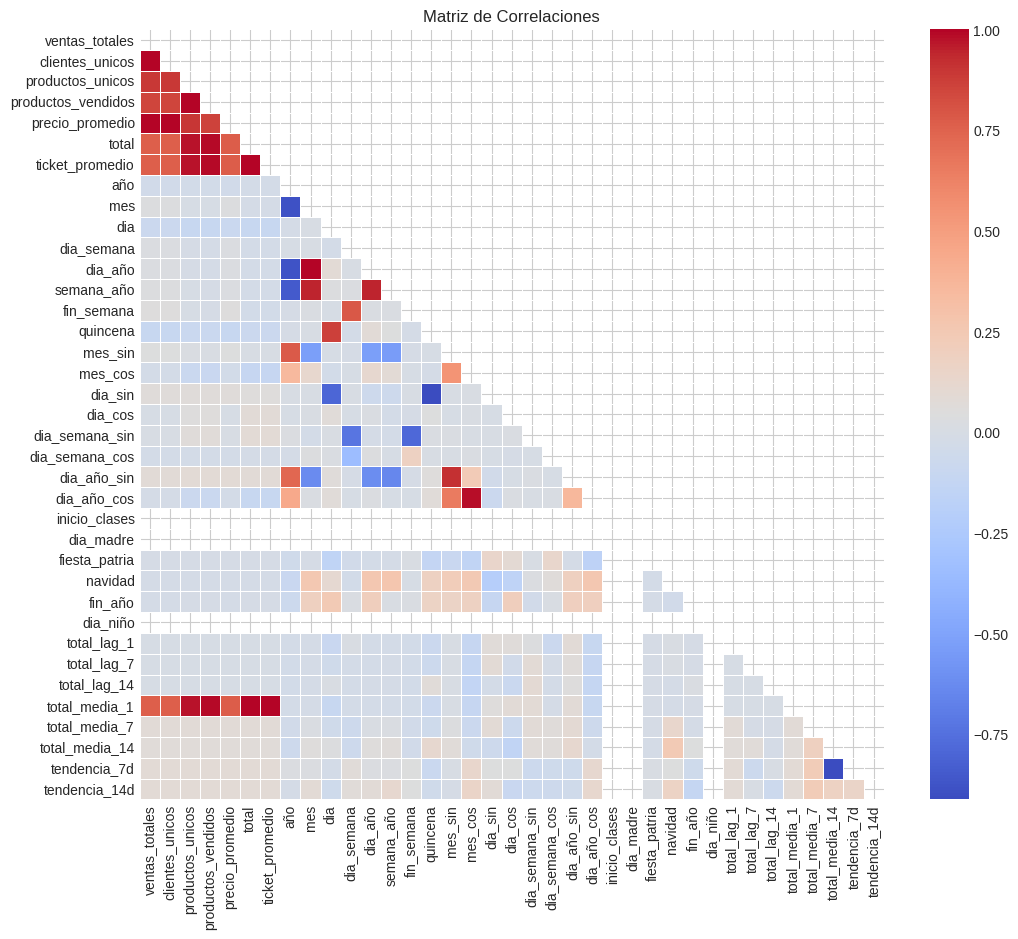

Preparando datos para modelado...
Período analizado: 2024-07-03 a 2025-01-30
Fecha de corte para división train/test: 2025-01-15
Datos de entrenamiento: 197 días
Datos de prueba: 15 días
Dimensiones de datos de entrenamiento: (197, 33)
Dimensiones de datos de prueba: (15, 33)
Dimensiones de datos futuros: (210, 33)
Datos preparados: 197 registros de entrenamiento, 15 de prueba
Período de predicción futuro: 2025-01-31 a 2025-08-28 (210 días)

Verificando valores faltantes en los datos...
Columnas con NaN en X_train: ['total_lag_1', 'total_lag_7', 'total_lag_14', 'total_media_7', 'total_media_14', 'tendencia_7d', 'tendencia_14d']
Total de NaN en X_train: 74
No hay valores faltantes en X_test
No hay valores faltantes en y_train
No hay valores faltantes en y_test

Reemplazando valores faltantes con la media...
Entrenando modelo de regresión lineal múltiple...

=== Evaluación del Modelo (regresión lineal múltiple) ===
RMSE en entrenamiento: Bs. 0.00
RMSE en prueba: Bs. 0.00
R² en entrenamie


=== RESUMEN DE INGRESOS PROYECTADOS ===
Total proyectado (próximos 210 días): Bs. 1062.26

Desglose por mes:
• Enero 2025.0: Bs. 5.06
• Febrero 2025.0: Bs. 141.63
• Marzo 2025.0: Bs. 156.81
• Abril 2025.0: Bs. 151.75
• Mayo 2025.0: Bs. 156.81
• Junio 2025.0: Bs. 151.75
• Julio 2025.0: Bs. 156.81
• Agosto 2025.0: Bs. 141.63



Modelo guardado como 'modelo_prediccion_ingresos_regresion_lineal.pkl'
¡Proceso de modelado completado con éxito!


In [16]:
# SECCIÓN 4: EJECUCIÓN DEL MODELADO

# Rutas de los archivos CSV
ruta_ventas = 'ventas.csv'
ruta_productos = 'productos.csv'
ruta_ventas_detalle = 'ventadetalles.csv'
ruta_clientes = 'clientes.csv'

# Horizonte de predicción (días)
horizonte = 210

# Cargar datos (asegúrate de usar pd.read_csv en lugar de pd.read_excel)
def cargar_datos_csv(ruta_ventas, ruta_productos, ruta_ventas_detalle, ruta_clientes):
    try:
        # Cargar los datos
        ventas = pd.read_csv(ruta_ventas)
        productos = pd.read_csv(ruta_productos)
        ventas_detalle = pd.read_csv(ruta_ventas_detalle)
        clientes = pd.read_csv(ruta_clientes)

        print(f"Ventas: {ventas.shape[0]} registros")
        print(f"Productos: {productos.shape[0]} registros")
        print(f"Ventas detalle: {ventas_detalle.shape[0]} registros")
        print(f"Clientes: {clientes.shape[0]} registros")

        # Mostrar columnas de cada tabla para diagnóstico
        print("\nColumnas en ventas:", ventas.columns.tolist())
        print("Columnas en productos:", productos.columns.tolist())
        print("Columnas en ventas_detalle:", ventas_detalle.columns.tolist())
        print("Columnas en clientes:", clientes.columns.tolist())

        # Mostrar las primeras filas de cada tabla
        print("\nPrimeras filas de ventas:")
        print(ventas.head(2))

        return ventas, productos, ventas_detalle, clientes

    except Exception as e:
        print(f"Error al cargar datos: {e}")
        return None, None, None, None

# Cargar datos
ventas, productos, ventas_detalle, clientes = cargar_datos_csv(
    ruta_ventas, ruta_productos, ruta_ventas_detalle, ruta_clientes)

# Preparar datos diarios usando la nueva función específica para MongoDB
df_ventas = preparar_datos_diarios_mongodb(ventas, productos, ventas_detalle, clientes)

# Verificar si la preparación de datos fue exitosa
if df_ventas is None:
    print("ERROR: No se pudieron preparar los datos diarios. Terminando ejecución.")
else:
    # Continuar con el análisis si los datos se prepararon correctamente

    # Agregar características temporales
    df_ventas = extraer_caracteristicas_temporales(df_ventas)
    df_ventas = añadir_eventos_bolivia(df_ventas)
    df_ventas = crear_caracteristicas_lag(df_ventas)
    df_ventas.head()
    # Realizar análisis exploratorio
    analisis_exploratorio(df_ventas)

    # Preparar datos para modelado
    X_train, X_test, y_train, y_test, fechas_test, X_future, fechas_future = preparar_datos_modelado(
        df_ventas, horizonte=horizonte
    )

    # Entrenar modelo de regresión lineal múltiple
    model, pred, rmse, r2 = entrenar_modelo_regresion_lineal(
        X_train, y_train, X_test, y_test
    )

    # Realizar predicciones futuras
    y_future_raw = model.predict(
       pd.DataFrame(
        model.imputer.transform(X_future),
        columns=X_future.columns
      )
    )

    # Aplicar correcciones para predicciones más realistas
    y_future = aplicar_correcciones_predicciones(y_future_raw)

    # Visualizar predicciones
    fig_predicciones = plot_predicciones_mejorado(fechas_test, y_test, pred, fechas_future, y_future)
    fig_predicciones.show()

    # Calcular ingresos mensuales
    fig_ingresos_mensuales, ingresos_mes = calcular_ingresos_mensuales(fechas_future, y_future)
    fig_ingresos_mensuales.show()

    # Guardar modelo
    guardar_modelo(model)

    print("¡Proceso de modelado completado con éxito!")
